# KMeans

Based on <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [4]:
from common.data import get_data
from common.paths import HEALTHY, ADHD

X, Y, demographics, population = get_data(label_path=ADHD)
ages = demographics['Age']
sexes = demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [5]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Run Silhouette Analysis

In [55]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.095638305
For n_clusters = 3 The average silhouette_score is : 0.042641126
For n_clusters = 4 The average silhouette_score is : 0.045913357
For n_clusters = 5 The average silhouette_score is : 0.052227885


In [56]:
two_clusters = KMeans(n_clusters=2)
cluster_labels = two_clusters.fit_predict(X)

cluster_one_indices = np.where(cluster_labels == 0)
cluster_two_indices = np.where(cluster_labels == 1)

silhouette_avg = silhouette_score(X, cluster_labels)
print('silhouette_avg:', silhouette_avg)

silhouette_avg: 0.095942706


In [57]:
# X_cluster_one, X_cluster_two = X[cluster_one_indices], X[cluster_two_indices]
ages_cluster_one, ages_cluster_two = ages[cluster_one_indices], ages[cluster_two_indices]
sexes_cluster_one, sexes_cluster_two = sexes[cluster_one_indices], sexes[cluster_two_indices]

In [58]:
print('Age mean:', np.mean(ages_cluster_one), np.mean(ages_cluster_two))
print('Sex proportion:', np.unique(sexes_cluster_one, return_counts=True), np.unique(sexes_cluster_two, return_counts=True))

Age mean: 10.18999636585366 10.075952015384617
Sex proportion: (array([0, 1]), array([23, 18])) (array([0, 1]), array([39, 26]))


WISC_FSIQ mean: 109.34146341463415 108.1076923076923
WISC_VSI mean: 103.1951219512195 106.47692307692307
WISC_VCI mean: 109.5609756097561 111.23076923076923
WISC_FRI mean: 108.5609756097561 106.70769230769231
WISC_WMI mean: 104.78048780487805 103.36923076923077
WISC_PSI mean: 109.34146341463415 104.78461538461538


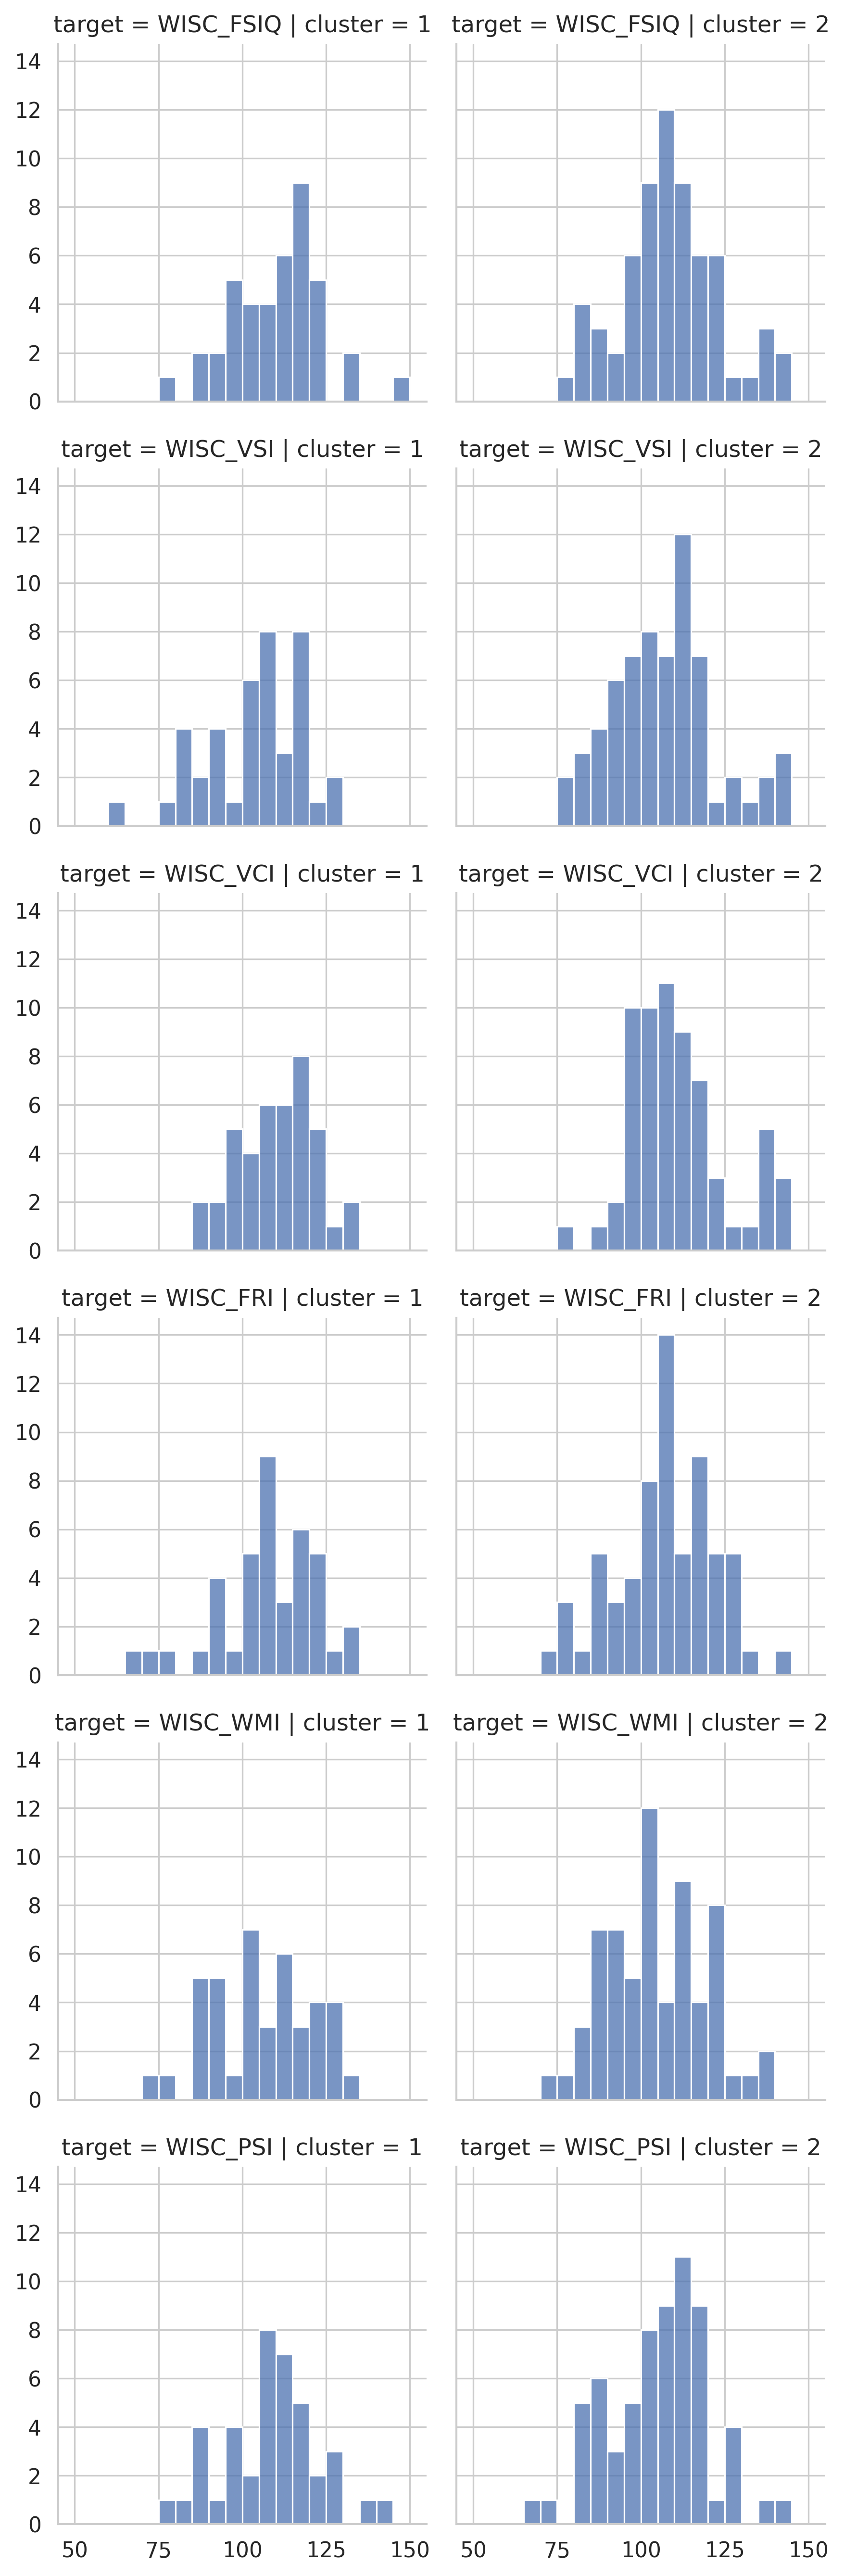

In [59]:
from common.wisc import WISC_LEVEL

data = []

for target in WISC_LEVEL[5]:
    y = Y[target]
    y_cluster_one, y_cluster_two = y[cluster_one_indices], y[cluster_two_indices]
    print(f'{target} mean:', np.mean(y_cluster_one), np.mean(y_cluster_two))

    data += [(1, target, value) for value in y_cluster_one]
    data += [(2, target, value) for value in y_cluster_two]

data = pd.DataFrame(data, columns=['cluster', 'target', 'value'])
# display(data)
g = sns.FacetGrid(data, col="cluster", row="target")
g.map_dataframe(sns.histplot, x='value', binwidth=5, binrange=(50, 150))

### Calculate Bayesian Information Criterion

In [ ]:
%%time

range_n_clusters = [n for n in range(2, 15)]
bics = []
X_ss = StandardScaler().fit_transform(X)

for n_clusters in range_n_clusters:
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='diag', reg_covar=1e-5, verbose=1)
    gmm.fit(X_ss)
    bics.append(gmm.bic(X_ss))

print(bics)

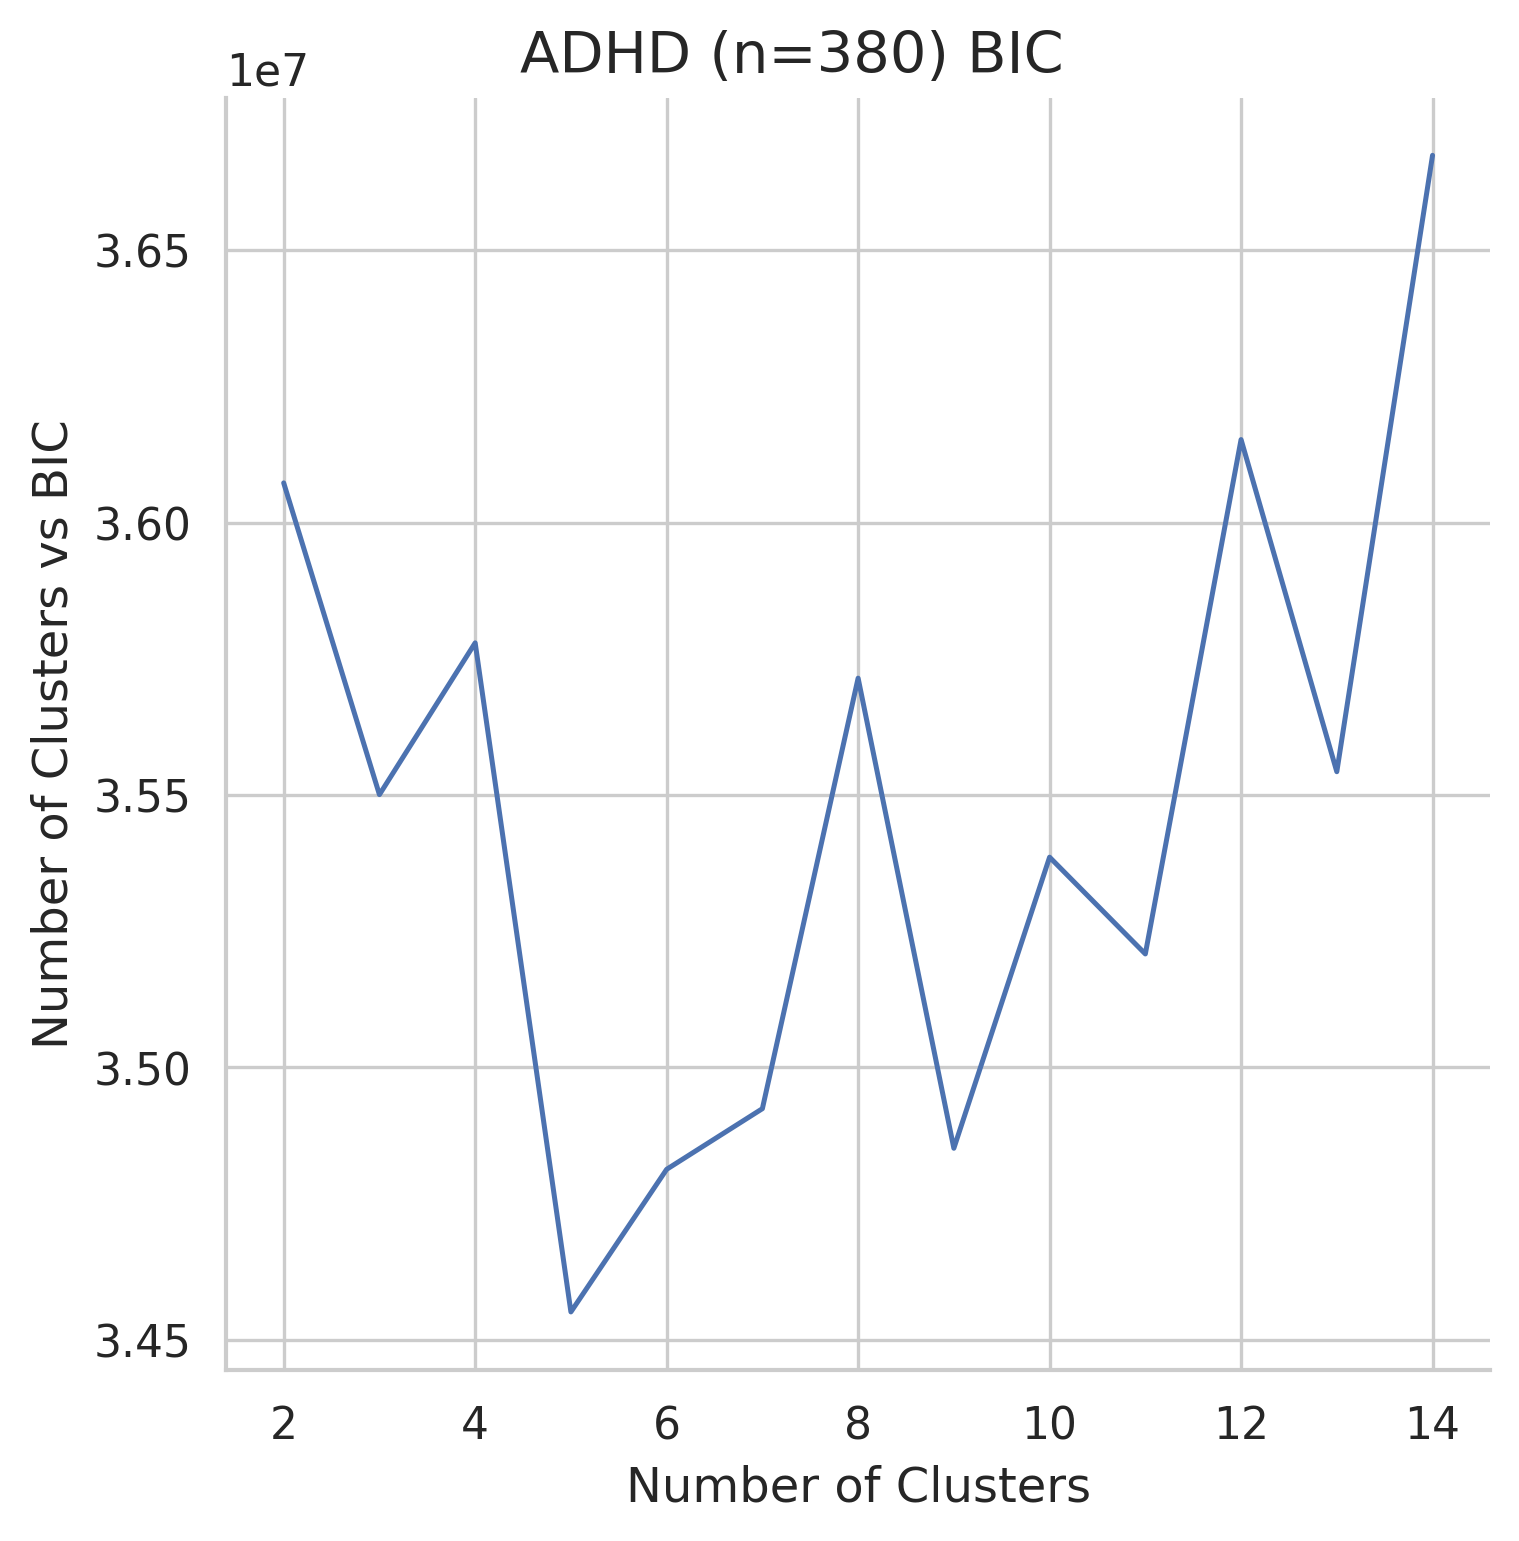

In [20]:
g = sns.relplot(x=range_n_clusters, y=bics, kind="line")
g.fig.suptitle('ADHD (n=380) BIC')
g.set_axis_labels('Number of Clusters', 'Number of Clusters vs BIC')